In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import scipy as sc 
import numpy as np
import cvxpy as cvx
import pickle

import sys
import os
import importlib

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

import covariance_functions.general_functions as gf
import covariance_functions.em_functions as em
import covariance_functions.ewma_functions as ewma
import covariance_functions.regularization_functions as reg
import covariance_functions.backtest_functions as bt
import covariance_functions.portfolio_functions as pf
import covariance_functions.tradingmodel_functions as tm


print(f"import start")
importlib.reload(gf)
importlib.reload(em)
importlib.reload(ewma)
importlib.reload(reg)
importlib.reload(bt)
importlib.reload(pf)
importlib.reload(tm)
print(f"import end")

from covariance_functions.em_functions import *
from covariance_functions.ewma_functions import *
from covariance_functions.ewma_functions import _ewma_cov
from covariance_functions.ewma_functions import iterated_ewma
from covariance_functions.general_functions import *
from covariance_functions.regularization_functions import *
from covariance_functions.backtest_functions import *
from covariance_functions.portfolio_functions import *
from covariance_functions.tradingmodel_functions import *
from covariance_functions.tradingmodel_functions import Trader

import start
import end


# Import Data and Data Pre-Processing

In [2]:
returns = pd.read_csv('data/returns_large_universe.csv')
returns = returns.set_index('date')
returns = returns.rename_axis('Date', axis='index')
returns.index = pd.to_datetime(returns.index, format='%Y-%m-%d')

FF = pd.read_csv('data/ff5.csv')
FF = FF.set_index('Unnamed: 0')
FF = FF.rename_axis('Date', axis='index')
FF.index = pd.to_datetime(FF.index, format='%Y-%m-%d')

rf_rate = pd.DataFrame(FF.loc[:,"RF"])
rf_rate.index = pd.to_datetime(rf_rate.index, format='%Y%m%d')

In [3]:
mapping_data=pd.read_csv('data/permno_to_ticker_mapping.csv')
mapping_df = pd.DataFrame(mapping_data)
returns.columns = returns.columns.astype(str)
permno_to_ticker = dict(zip(mapping_df['PERMNO'].astype(str), mapping_df['tic']))
returns.rename(columns=permno_to_ticker, inplace=True)

In [19]:
returns
csv_file_path = 'data/returns_data.csv'
returns.to_csv(csv_file_path)
csv_file_path

'data/returns_data.csv'

In [4]:
returns

,MSFT,GE,CSCO,WMT,INTC,XOM,IBM,C,ORCL,T,...,FE,AB,HBAN,HSY,HES,CINF,ECL,SKM,ZION,NUE
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,-0.001606,-0.030695,0.008751,-0.032550,0.056948,-0.029480,0.071842,-0.050505,0.054099,-0.032051,...,-0.027548,-0.006263,-0.060209,-0.022398,-0.039648,-0.021042,-0.036741,0.009772,-0.062302,-0.009122
2000-01-04,-0.033780,-0.038750,-0.056102,-0.039252,-0.046695,-0.017586,-0.030811,-0.042553,-0.088360,-0.062252,...,0.000000,-0.004202,-0.030641,-0.037736,-0.019495,-0.001024,-0.026534,-0.103226,-0.048423,-0.010357
2000-01-05,0.010544,-0.005202,-0.003064,-0.019455,0.008289,0.054516,0.035137,0.003704,-0.052815,0.015537,...,0.036827,0.004219,-0.025862,0.004202,-0.008187,0.010246,0.039182,-0.028777,-0.001183,0.027907
2000-01-06,-0.033498,0.015577,-0.016595,0.010913,-0.058296,0.049383,-0.008621,0.065191,-0.058824,-0.021001,...,0.002732,0.016807,0.035398,0.026499,0.021226,0.006085,0.044262,-0.007407,0.014218,0.009050
2000-01-07,0.013068,0.038721,0.058750,0.075564,0.041270,-0.000735,-0.013043,-0.002309,0.076823,0.008571,...,0.005450,0.033058,0.008547,0.002717,0.042725,0.020161,0.000000,0.123134,0.002336,0.003363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-23,0.002267,0.000245,0.003381,0.002021,0.004621,0.026445,0.005466,0.006138,0.004473,0.002189,...,0.014493,-0.015795,0.010065,0.004044,0.047154,0.006843,0.010416,0.010531,0.003521,-0.006062
2022-12-27,-0.007414,0.012838,0.001053,0.000278,-0.005749,0.013894,0.005436,0.002937,0.001608,0.008192,...,0.006190,-0.005544,-0.000712,-0.000636,0.012211,-0.000191,0.006296,0.011843,0.008050,0.003380
2022-12-28,-0.010255,-0.010502,-0.009678,-0.017523,-0.015420,-0.016426,-0.016852,0.005181,-0.008027,-0.013001,...,-0.004496,-0.027876,-0.004274,-0.012133,-0.033261,-0.016565,-0.011344,-0.015918,-0.017813,-0.017211


# Constructing CM-IEWMA

In [5]:
# provided
"""
rw_memory = rolling window size
    - reflect the number of trading days considered relevant.
    - 3 months = 60 days
    - 6 months = 125 days
    - 1 year = 250 days
ewma_halflife
iewma_pair = tuple (volatility halflife, covariance halflife) for a single iewma
cm_iewma_pairs = list of tuples of iewma_pairs
    - looks like the pairs are chosen to capture a variety of date ranges, from short term to 1 year
"""
rw_memory = 250
ewma_halflife=125
iewma_pair = (63,125)
cm_iewma_pairs = [(10, 21), (21, 63), (63, 125), (125, 250), (250, 500)] # (21, 63), (63, 125), (125, 250), , (250, 500)

In [6]:
# CM-IEWMA
iewmas = {f"{pair[0]}-{pair[1]}": list(iterated_ewma(returns, vola_halflife=pair[0], cov_halflife=pair[1], min_periods_vola=63, min_periods_cov=63)) for pair in cm_iewma_pairs}
Sigmas = {key: {item.time: item.covariance for item in iewma} for key, iewma in iewmas.items()}

# Regularize the covariance matrices for positive-definiteness
for i in range(len(cm_iewma_pairs)):
    fast = cm_iewma_pairs[i]; fast = f"{fast[0]}-{fast[1]}"
    Sigmas[fast] = add_to_diagonal(Sigmas[fast], lamda=0.05)

results = list(from_sigmas(Sigmas, returns, means=None).solve(window=10))

Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma
Running iterated_ewma


c:\Users\krupi\anaconda3\envs\mfe230e\Lib\site-packages\cvxpy\reductions\solvers\solving_chain.py:246: UserWarning: Your problem has too many parameters for efficient DPP compilation. We suggest setting 'ignore_dpp = True'.
  warnings.warn(


Solver did not converge at time 2001-05-31 00:00:00
Solver did not converge at time 2001-06-21 00:00:00
Solver did not converge at time 2001-06-22 00:00:00
Solver did not converge at time 2001-07-10 00:00:00
Solver did not converge at time 2001-07-16 00:00:00
Solver did not converge at time 2001-07-17 00:00:00
Solver did not converge at time 2001-07-18 00:00:00
Solver did not converge at time 2001-07-20 00:00:00
Solver did not converge at time 2001-07-24 00:00:00
Solver did not converge at time 2001-08-06 00:00:00
Solver did not converge at time 2001-08-07 00:00:00
Solver did not converge at time 2001-08-09 00:00:00
Solver did not converge at time 2001-08-29 00:00:00
Solver did not converge at time 2001-09-04 00:00:00
Solver did not converge at time 2001-10-18 00:00:00
Solver did not converge at time 2001-12-14 00:00:00
Solver did not converge at time 2001-12-17 00:00:00
Solver did not converge at time 2001-12-19 00:00:00
Solver did not converge at time 2001-12-20 00:00:00
Solver did n

In [10]:
with open('weights.pkl', 'wb') as f:
    pickle.dump(weights, f)

In [7]:
cm_iewma = {}
weights = {}
for result in results:
    try:
        cm_iewma[result.time] = result.covariance
        weights[result.time] = result.weights
        
    except AttributeError:
        continue

In [14]:
weights[pd.to_datetime('2008-01-03')]

10-21      2.492837e-02
21-63      1.195184e-01
63-125     1.358455e-11
125-250    2.659048e-01
250-500    5.896484e-01
dtype: float64

C:\Users\krupi\AppData\Local\Temp\ipykernel_18016\2483122190.py:5: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  quarterly_weights  = pd.DataFrame(weights).T.resample("Y").mean().loc[start_date:end_date]


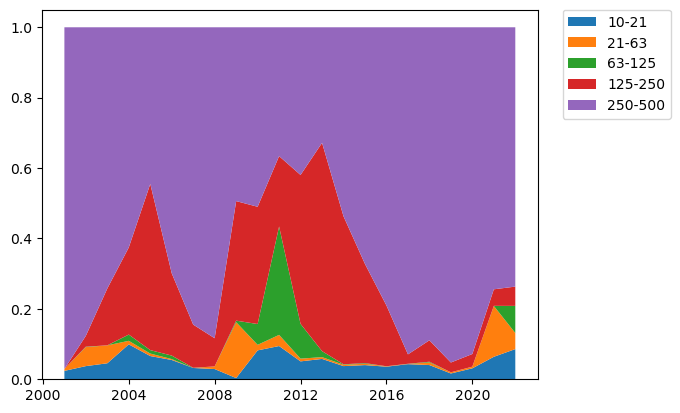

In [25]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2000-12-28", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

quarterly_weights  = pd.DataFrame(weights).T.resample("Y").mean().loc[start_date:end_date]

plt.stackplot(quarterly_weights.index, quarterly_weights.values.T, labels=[f"{pair[0]}-{pair[1]}" for pair in cm_iewma_pairs])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.);

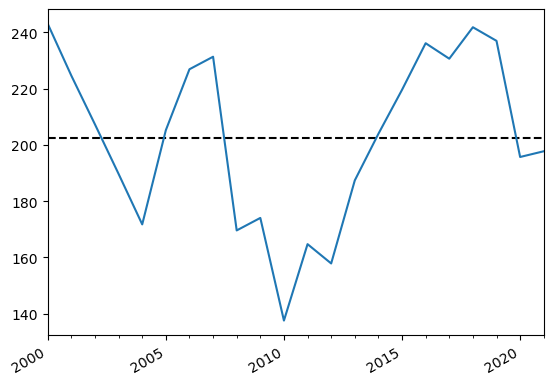

In [26]:
halflifes_vola = np.array([cm_iewma_pairs[i][0] for i in range(len(cm_iewma_pairs))])
(quarterly_weights * halflifes_vola).sum(axis=1).plot()
plt.axhline((quarterly_weights * halflifes_vola).sum(axis=1).mean(), color="black", linestyle="--", label="Mean half-life", zorder=-1);
plt.gcf().autofmt_xdate()

# Fitting Other Models

# Crisis Case Study

In [36]:
dot_com_crash = returns.loc['2000-03-01': '2002-03-01']
gfc = returns.loc['2007-02-01': '2008-12-31']
covid = returns.loc['2020-02-20': '2020-04-20']

In [38]:
# Estimators except MGARCH

# general_functions: rolling_window
rw = rolling_window(returns, rw_memory)

# ewma_functions: ewma
ewma = dict(_ewma_cov(returns, halflife=ewma_halflife))

#ewma_functions: iterated_ewma  
iewma = list(iterated_ewma(returns, vola_halflife=iewma_pair[0],cov_halflife=iewma_pair[1]))
iewma = {iterate.time: iterate.covariance for iterate in iewma}

# Prescient 
prescient = {}
for t in returns.index:
    # get sample covariance matrix for corresponding quarter
    quarter = (t.month-1)//3 + 1
    cov = np.cov(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, rowvar=False)
    mean = np.mean(returns.loc[(returns.index.year == t.year) & (returns.index.quarter == quarter)].values, axis=0)
    prescient[t] = pd.DataFrame(cov+np.outer(mean, mean), index=returns.columns, columns=returns.columns)

Running iterated_ewma


In [ ]:
# MGARCH Estimator
mgarch_cond_cov = pd.read_csv("mgarch_predictors_from_R/stocks/mgarch_stocks_adj.csv", index_col=None)
Sigmas = from_row_matrix_to_covariance(mgarch_cond_cov.values, returns.shape[1]) / 10000

# Remove first year since it was used for training
times = dot_com_crash.index[249:] 
mgarch = {times[t]: pd.DataFrame(Sigmas[t], index=dot_com_crash.columns, columns=dot_com_crash.columns) for t in range(Sigmas.shape[0])}

### Presets

In [ ]:
# Define start and end of backtest; first two years used for training/burn-in
start_date = pd.to_datetime("2000-03-01", format="%Y-%m-%d")
# start_date = pd.to_datetime("2010-01-04", format="%Y-%m-%d")
end_date = pd.to_datetime("2022-12-30", format="%Y-%m-%d")

In [ ]:
names = ["RW", "EWMA", "IEWMA", "CM-IEWMA", "Prescient"]

predictors_temp = [rw, ewma, iewma, mgarch, cm_iewma, prescient]
predictors = []

for predictor in predictors_temp:
    predictors.append({t: predictor[t] for t in predictor.keys() if t >= start_date and t <= end_date})

In [ ]:
for i, predictior in enumerate(predictors):
    MSE_temp = MSE(returns, predictior).resample("Q").mean()

    print("\n" + names[i])
    print(f"mean: {MSE_temp.mean():.6f}")
    print(f"std: {MSE_temp.std():.6f}")
    print(f"max: {MSE_temp.max():.6f}")